In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
from torchvision import transforms, datasets
BATCH_SIZE = 64 

train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.47MB/s]


In [2]:
import torch.nn.functional as F
from torchinfo import summary
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.8.0+cu126  Device: cuda


In [4]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

In [5]:
def train(model, train_loader, optimizer, criterion, device, epoch, log_interval, batch_size):
    global loss, label
    model.train()
    correct = 0
    train_loss = 0
    total_samples = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device) 

        optimizer.zero_grad()

        output = model(image) 

        loss = criterion(output, label)

        train_loss += loss.item() * label.size(0)
        loss.backward()
        optimizer.step()

        preds = output.argmax(dim=1) 

        correct += (preds == label).sum().item()
        total_samples += label.size(0)

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, total_samples,
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    train_loss /= total_samples
    train_accuracy = 100. * correct / total_samples

    return train_loss, train_accuracy

In [6]:
def evaluate(model, test_loader):
    model.eval() # 평가 모드 전환 (드롭아웃, 배치 정규화 등 비활성화)
    test_loss = 0
    correct = 0

    with torch.no_grad(): # 기울기 계산 비활성화 (메모리 절약 및 속도 향상)
        for images, labels in test_loader: # 복수형(images, labels)으로 통일 권장
            # 1. 데이터를 동일한 장치(GPU/CPU)로 이동
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # 2. 모델 예측
            outputs = model(images)

            # 3. 손실 계산 및 누적
            # criterion의 결과는 보통 배치당 평균이므로, 전체 평균을 구하기 위해 배치 크기를 곱해줍니다.
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0) 

            # 4. 정확도 계산
            predictions = outputs.argmax(dim=1) # 가장 높은 확률을 가진 인덱스 추출
            correct += (predictions == labels).sum().item() # 현재 배치의 정답 수 누적

    # 전체 데이터셋에 대한 평균 손실과 정확도 계산
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

In [7]:
class early_stopping:
  def __init__(self, patience, verbose, delta, path='checkpoint.pt'):
    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.count = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.inf
    self.path = path


  def __call__(self, val_loss, model):
    score = -val_loss


    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.count += 1
      if self.verbose:
        print(f"Early Stopping counter: {self.count} out of {self.patience}")


      if self.count >= self.patience:
        self.early_stop = True  
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.count =0  


  def save_checkpoint(self, val_loss, model):
    if self.verbose:
      print(f"Validation loss decreased ({self.val_loss_min:.6f}) --> {val_loss:.6f}. saving model..")
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss

In [8]:
patience = 2
EPOCHS = 50

In [9]:
import numpy as np
early_stopping = early_stopping(patience=2, verbose=True, path='best_model.pt', delta=0)
loss_hist_train     = [0] * EPOCHS
accuracy_hist_train = [0] * EPOCHS
loss_hist_valid     = [0] * EPOCHS
accuracy_hist_valid = [0] * EPOCHS
for epoch in range(1, EPOCHS + 1):
    loss_, acc_ = train(model, train_loader, optimizer, criterion, DEVICE, epoch, log_interval = 200, batch_size=BATCH_SIZE)
    loss_hist_train[epoch-1] = loss_
    accuracy_hist_train[epoch-1] = acc_
    test_loss, test_accuracy = evaluate(model, test_loader)
    loss_hist_valid[epoch-1] = test_loss
    accuracy_hist_valid[epoch-1] = test_accuracy
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Train Epoch: 1 [64/60000 (0%)]	Train Loss: 2.347600
Train Epoch: 1 [12864/60000 (21%)]	Train Loss: 2.294717
Train Epoch: 1 [25664/60000 (43%)]	Train Loss: 2.294344
Train Epoch: 1 [38464/60000 (64%)]	Train Loss: 2.319076
Train Epoch: 1 [51264/60000 (85%)]	Train Loss: 2.321238

[EPOCH: 1], 	Test Loss: 2.2841, 	Test Accuracy: 18.05 % 

Validation loss decreased (inf) --> 2.284054. saving model..
Train Epoch: 2 [64/60000 (0%)]	Train Loss: 2.281987
Train Epoch: 2 [12864/60000 (21%)]	Train Loss: 2.287855
Train Epoch: 2 [25664/60000 (43%)]	Train Loss: 2.275951
Train Epoch: 2 [38464/60000 (64%)]	Train Loss: 2.308644
Train Epoch: 2 [51264/60000 (85%)]	Train Loss: 2.240340

[EPOCH: 2], 	Test Loss: 2.2256, 	Test Accuracy: 21.72 % 

Validation loss decreased (2.284054) --> 2.225596. saving model..
Train Epoch: 3 [64/60000 (0%)]	Train Loss: 2.261225
Train Epoch: 3 [12864/60000 (21%)]	Train Loss: 2.177614
Train Epoch: 3 [25664/60000 (43%)]	Train Loss: 2.146069
Train Epoch: 3 [38464/60000 (64%)]	Trai

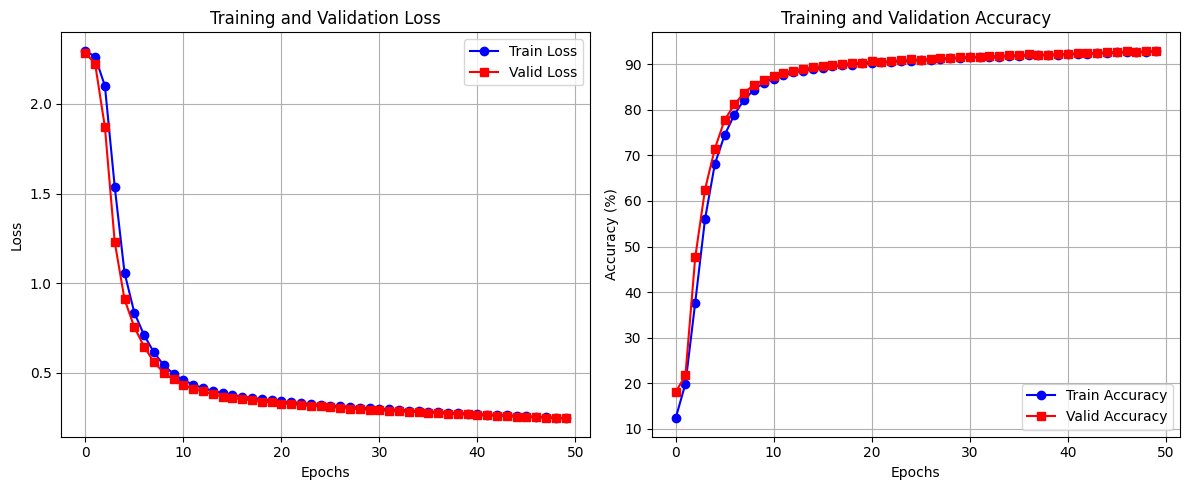

In [10]:
import matplotlib.pyplot as plt
epochs_range = np.arange(1,50)
epochs_range = np.arange(0, len(loss_hist_train))
plt.figure(figsize=(12, 5)) # 전체 그래프 크기 설정

# --- 첫 번째 그래프: Loss (손실) ---
plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째
plt.plot(epochs_range, loss_hist_train, label='Train Loss', color='blue', marker='o')
plt.plot(epochs_range, loss_hist_valid, label='Valid Loss', color='red', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# --- 두 번째 그래프: Accuracy (정확도) ---
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째
plt.plot(epochs_range, accuracy_hist_train, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_range, accuracy_hist_valid, label='Valid Accuracy', color='red', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()

In [11]:
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())


test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170M/170M [00:23<00:00, 7.17MB/s] 


In [12]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


In [13]:
X_train.shape

torch.Size([64, 3, 32, 32])

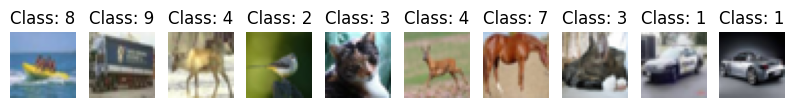

In [14]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))


for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [15]:
import torch.nn.functional as F
from torchinfo import summary
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [16]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)



model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

Using PyTorch version: 2.8.0+cu126  Device: cuda


In [17]:
from torchinfo import summary
summary(model, input_size=(64, 3*32*32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 10]                  --
├─Linear: 1-1                            [64, 512]                 1,573,376
├─Linear: 1-2                            [64, 256]                 131,328
├─Linear: 1-3                            [64, 10]                  2,570
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 109.27
Input size (MB): 0.79
Forward/backward pass size (MB): 0.40
Params size (MB): 6.83
Estimated Total Size (MB): 8.01

In [19]:
import numpy as np


class early_stopping:
  def __init__(self, patience, verbose, delta, path='checkpoint.pt'):
    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.count = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.inf
    self.path = path


  def __call__(self, val_loss, model):
    score = -val_loss


    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.count += 1
      if self.verbose:
        print(f"Early Stopping counter: {self.count} out of {self.patience}")


      if self.count >= self.patience:
        self.early_stop = True  
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.count =0  


  def save_checkpoint(self, val_loss, model):
    if self.verbose:
      print(f"Validation loss decreased ({self.val_loss_min:.6f}) --> {val_loss:.6f}. saving model..")
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss



patience = 2
EPOCHS = 50

early_stopping = early_stopping(patience=2, verbose=True, path='best_model.pt', delta=0)
loss_hist_train     = [0] * EPOCHS
accuracy_hist_train = [0] * EPOCHS
loss_hist_valid     = [0] * EPOCHS
accuracy_hist_valid = [0] * EPOCHS
for epoch in range(1, EPOCHS + 1):
    loss_, acc_ = train(model, train_loader, optimizer, criterion, DEVICE, epoch, log_interval = 200, batch_size=BATCH_SIZE)
    loss_hist_train[epoch-1] = loss_
    accuracy_hist_train[epoch-1] = acc_
    test_loss, test_accuracy = evaluate(model, test_loader)
    loss_hist_valid[epoch-1] = test_loss
    accuracy_hist_valid[epoch-1] = test_accuracy
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break


Train Epoch: 1 [64/50000 (0%)]	Train Loss: 2.362871
Train Epoch: 1 [12864/50000 (26%)]	Train Loss: 2.286180
Train Epoch: 1 [25664/50000 (51%)]	Train Loss: 2.285820
Train Epoch: 1 [38464/50000 (77%)]	Train Loss: 2.284344

[EPOCH: 1], 	Test Loss: 2.2985, 	Test Accuracy: 18.57 % 

Validation loss decreased (inf) --> 2.298530. saving model..
Train Epoch: 2 [64/50000 (0%)]	Train Loss: 2.312089
Train Epoch: 2 [12864/50000 (26%)]	Train Loss: 2.287375
Train Epoch: 2 [25664/50000 (51%)]	Train Loss: 2.278969
Train Epoch: 2 [38464/50000 (77%)]	Train Loss: 2.268907

[EPOCH: 2], 	Test Loss: 2.2562, 	Test Accuracy: 19.18 % 

Validation loss decreased (2.298530) --> 2.256229. saving model..
Train Epoch: 3 [64/50000 (0%)]	Train Loss: 2.266086
Train Epoch: 3 [12864/50000 (26%)]	Train Loss: 2.193275
Train Epoch: 3 [25664/50000 (51%)]	Train Loss: 2.187927
Train Epoch: 3 [38464/50000 (77%)]	Train Loss: 2.133734

[EPOCH: 3], 	Test Loss: 2.1426, 	Test Accuracy: 17.44 % 

Validation loss decreased (2.256229)

In [20]:
import torch.nn.functional as F
from torchinfo import summary
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [21]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

In [22]:
from torchinfo import summary
summary(model, input_size=(64, 3*32*32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 10]                  --
├─Linear: 1-1                            [64, 512]                 1,573,376
├─Linear: 1-2                            [64, 256]                 131,328
├─Linear: 1-3                            [64, 10]                  2,570
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 109.27
Input size (MB): 0.79
Forward/backward pass size (MB): 0.40
Params size (MB): 6.83
Estimated Total Size (MB): 8.01

In [23]:
import numpy as np


class early_stopping:
  def __init__(self, patience, verbose, delta, path='checkpoint.pt'):
    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.count = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.inf
    self.path = path


  def __call__(self, val_loss, model):
    score = -val_loss


    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.count += 1
      if self.verbose:
        print(f"Early Stopping counter: {self.count} out of {self.patience}")


      if self.count >= self.patience:
        self.early_stop = True  
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.count =0  


  def save_checkpoint(self, val_loss, model):
    if self.verbose:
      print(f"Validation loss decreased ({self.val_loss_min:.6f}) --> {val_loss:.6f}. saving model..")
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss



patience = 2
EPOCHS = 50

early_stopping = early_stopping(patience=2, verbose=True, path='best_model.pt', delta=0)
loss_hist_train     = [0] * EPOCHS
accuracy_hist_train = [0] * EPOCHS
loss_hist_valid     = [0] * EPOCHS
accuracy_hist_valid = [0] * EPOCHS
for epoch in range(1, EPOCHS + 1):
    loss_, acc_ = train(model, train_loader, optimizer, criterion, DEVICE, epoch, log_interval = 200, batch_size=BATCH_SIZE)
    loss_hist_train[epoch-1] = loss_
    accuracy_hist_train[epoch-1] = acc_
    test_loss, test_accuracy = evaluate(model, test_loader)
    loss_hist_valid[epoch-1] = test_loss
    accuracy_hist_valid[epoch-1] = test_accuracy
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Train Epoch: 1 [64/50000 (0%)]	Train Loss: 2.287104
Train Epoch: 1 [12864/50000 (26%)]	Train Loss: 2.157598
Train Epoch: 1 [25664/50000 (51%)]	Train Loss: 1.928870
Train Epoch: 1 [38464/50000 (77%)]	Train Loss: 2.012679

[EPOCH: 1], 	Test Loss: 1.9212, 	Test Accuracy: 30.67 % 

Validation loss decreased (inf) --> 1.921176. saving model..
Train Epoch: 2 [64/50000 (0%)]	Train Loss: 1.854041
Train Epoch: 2 [12864/50000 (26%)]	Train Loss: 1.892305
Train Epoch: 2 [25664/50000 (51%)]	Train Loss: 1.954794
Train Epoch: 2 [38464/50000 (77%)]	Train Loss: 1.836697

[EPOCH: 2], 	Test Loss: 1.8156, 	Test Accuracy: 35.60 % 

Validation loss decreased (1.921176) --> 1.815570. saving model..
Train Epoch: 3 [64/50000 (0%)]	Train Loss: 1.803522
Train Epoch: 3 [12864/50000 (26%)]	Train Loss: 2.020626
Train Epoch: 3 [25664/50000 (51%)]	Train Loss: 1.862576
Train Epoch: 3 [38464/50000 (77%)]	Train Loss: 1.686823

[EPOCH: 3], 	Test Loss: 1.7436, 	Test Accuracy: 38.14 % 

Validation loss decreased (1.815570)

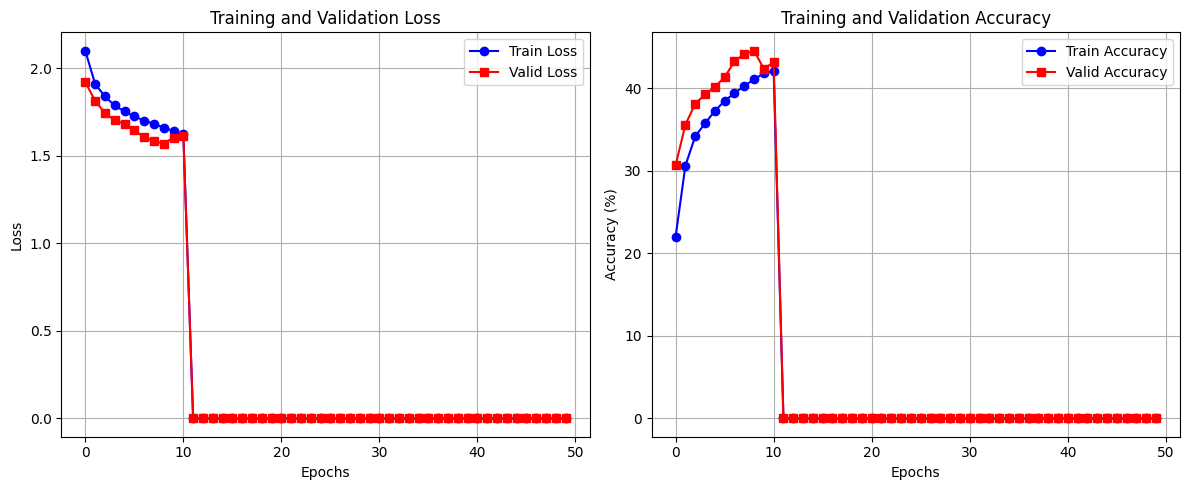

In [24]:
import matplotlib.pyplot as plt
epochs_range = np.arange(1,50)
epochs_range = np.arange(0, len(loss_hist_train))
plt.figure(figsize=(12, 5)) # 전체 그래프 크기 설정

# --- 첫 번째 그래프: Loss (손실) ---
plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째
plt.plot(epochs_range, loss_hist_train, label='Train Loss', color='blue', marker='o')
plt.plot(epochs_range, loss_hist_valid, label='Valid Loss', color='red', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# --- 두 번째 그래프: Accuracy (정확도) ---
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째
plt.plot(epochs_range, accuracy_hist_train, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_range, accuracy_hist_valid, label='Valid Accuracy', color='red', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()